# Project 1 — Seattle Airbnb Open Data

## 1 CRISP

##### Cross-Industry Process for Data Mining 

This project follows the CRISP-DM Process.

* Business Understanding 
* Data Understanding 
* Prepare Data 
* Data Modeling 
* Evaluate the Results 
* Deploy 

## 2 Business Understanding 

Airbnb is a platform that has been growing tremendously in the last couple of years. At least before the COVID-19 pandemic, travelling was more popular than ever, especially with the rise of Instagram bloggers that travel the world and share their impressions.

Therefore, many people see Airbnb as an opportunity to earn money. Maybe they are parents whose kids moved out already, which means they have some rooms to spare. Others might invest into real estate and use Airbnb as a platform to find potential tenants.

For those people, of course, one of the most interesting questions would be how they can maximize their return on investment. To assist our decision making with empirical data, I analyzed 3818 Airbnb listings from the Kaggle Seattle Airbnb dataset.

### 2.1 Questions

#### Question 1

One of the first things to look out for when it comes to real estate is the location. Therefore, I want to know which areas are most expensive and therefore maybe also most lucrative.

#### Question 2

Once the location is set, there might be other things we can optimize to maximize ROI. Maybe there are things on the listing page that we can tweak? Maybe we need to invest in amenities? Therefore, the question is: which factors have the highest impact on prices?

#### Question 3

A friend has an apartment in Seattle downtown that he wants to rent out via Airbnb. It has one big bedroom, a kitchen and one bathroom. Should he invest money to split the bedroom into two rooms?

## 3 Data Understanding

#### Import Packages

In [1]:
# Standard
import os
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  

# Modeling
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error 

from IPython import display 
%matplotlib inline
print('Imported packages')

Imported packages


#### Read Listings Data

In [2]:
df_listings = pd.read_csv('./Data/Seattle Airbnb Open Data/listings.csv') 
df_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [3]:
df_listings['listing_url'][0]

'https://www.airbnb.com/rooms/241032'

In [4]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

#### Read Calendar Data

In [5]:
df_calendar = pd.read_csv('./Data/Seattle Airbnb Open Data/calendar.csv') 
df_calendar.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
df_calendar['listing_id'].value_counts()

6752031     365
7404370     365
1259305     365
4672934     365
10310373    365
           ... 
9999759     365
9048029     365
8441477     365
7984550     365
9484823     365
Name: listing_id, Length: 3818, dtype: int64

In [7]:
df_calendar.shape

(1393570, 4)

In [8]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


#### Read Reviews Data

In [9]:
df_reviews = pd.read_csv('./Data/Seattle Airbnb Open Data/reviews.csv') 
df_reviews.head(2) 

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


In [10]:
df_reviews.shape

(84849, 6)

In [11]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


## 4 Prepare Data 

### Add columns

For URLs, add new columns indicating if they are available (e.g. availability of profile picture).

In [12]:
df_listings['thumbnail_available'] = df_listings['thumbnail_url'].notnull()
df_listings['picture_available'] = df_listings['picture_url'].notnull()
df_listings['xl_picture_available'] = df_listings['xl_picture_url'].notnull()
df_listings['host_thumbnail_available'] = df_listings['host_thumbnail_url'].notnull()
df_listings['host_picture_available'] = df_listings['host_picture_url'].notnull()
df_listings['host_about_available'] = df_listings['host_about'].notnull()
df_listings['notes_available'] = df_listings['notes'].notnull()
df_listings['security_deposit_required'] = df_listings['security_deposit'].notnull()
df_listings['weekly_booking_available'] = df_listings['weekly_price'].notnull()
df_listings['monthly_booking_available'] = df_listings['monthly_price'].notnull()

In [13]:
df_listings['amenities']

0       {TV,"Cable TV",Internet,"Wireless Internet","A...
1       {TV,Internet,"Wireless Internet",Kitchen,"Free...
2       {TV,"Cable TV",Internet,"Wireless Internet","A...
3       {Internet,"Wireless Internet",Kitchen,"Indoor ...
4       {TV,"Cable TV",Internet,"Wireless Internet",Ki...
                              ...                        
3813    {TV,"Cable TV",Internet,"Wireless Internet","A...
3814    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
3815    {"Cable TV","Wireless Internet",Kitchen,"Free ...
3816    {TV,"Wireless Internet",Kitchen,"Free Parking ...
3817    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, Length: 3818, dtype: object

I will omit the "amenities" column for this analysis, since I think this could be a whole other analysis. This is more relevant for when the real estate has already been obtained. Here it could also be interesting to investigate interaction effects or moderators.

### Show null values

In [14]:
def give_missing_values(df, visualize = False, viz_thresh=0.00): 

    ''' 
    INPUT  
        df - a dataframe
        visualize - Flag indicating if visualization should be returned
        viz_thresh - Threshold for fraction of missing values for row to be plotted

    OUTPUT 

        missing_values_df - a dataframe with the percentage of missing values for each column in the given dataframe
    ''' 

    percent_missing = df.isnull().sum() * 100 / len(df)
    
    missing_values_df = pd.DataFrame({'column_name': df.columns,
                                      'percent_missing': percent_missing})
    
    missing_values_df = round(missing_values_df.sort_values(by=['percent_missing'], 
                                       ascending=False), 2)
    missing_values_df_vis = missing_values_df[missing_values_df['percent_missing'] > viz_thresh]
    
    missing_values_df_vis = missing_values_df_vis.style.bar(align='mid', color=['#df4523'])
    
    
    if visualize:
        return missing_values_df_vis
    else:
        return missing_values_df

In [15]:
give_missing_values(df_listings, visualize=True, viz_thresh=0.05)

,column_name,percent_missing
license,license,100
square_feet,square_feet,97.46
monthly_price,monthly_price,60.27
security_deposit,security_deposit,51.13
weekly_price,weekly_price,47.38
notes,notes,42.06
neighborhood_overview,neighborhood_overview,27.03
cleaning_fee,cleaning_fee,26.98
transit,transit,24.46
host_about,host_about,22.5


### Drop columns for several reasons

* Drop text that can not be used in a model without transforming into numeric data
* Drop IDs, URLs, as they don't provide any valuable information
* Info is sufficiently available in a different column or no relevant information gain
* Drop columns when they have too many null values (>80%)

In [16]:
def drop_columns(df, column_list, print_info=False): 

    ''' 
    INPUT  
        df - a dataframe

    OUTPUT 

        missing_values_df - a dataframe with the percentage of missing values for each column in the given dataframe
        column_list - the columns of the given dataframe that should be dropped  
        print_info - a flag determining if some additional info should be printed
    ''' 
    
    df_dropped = df.copy()
    
    try:
        df_dropped = df_dropped.drop(columns=column_list)
    except:
        print('Something went wrong. Returning original Dataframe.')
        return df
   
    if print_info:
        print("Original dataframe: " + str(df.shape[0]) + " rows, " + str(df.shape[1]) + " columns.\n")
        print("Dropped the following columns:")
        for col in column_list:
            print("- " + col)
        print("\nNew dataframe: " + str(df_dropped.shape[0]) + " rows, " + str(df_dropped.shape[1]) + " columns.")
        
    return df_dropped

In [17]:
columns_to_drop_text = ['id', 'name', 'summary', 'space', 'description', 'notes', 'transit', 'host_name', 'host_about']
columns_to_drop_ids = ['scrape_id',  'listing_url',  'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url']
columns_to_drop_no_information_gain = ['street', 'neighborhood_overview', 'city', 'state', 'zipcode', 'smart_location', 'latitude', 'longitude', 
                                       'is_location_exact', 'last_scraped', 'host_location', 'security_deposit', 'first_review', 'last_review'
                                       , 'host_listings_count', 'reviews_per_month', 'weekly_price', 'monthly_price',
                                      'availability_30', 'availability_60', 'availability_90', 'host_has_profile_pic']
columns_to_drop_nulls = ['license', 'square_feet']
columns_too_much_effort = ['host_verifications', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood', 'calendar_updated', 'calculated_host_listings_count', 'cleaning_fee', 'amenities']

columns_to_drop_all = columns_to_drop_text + columns_to_drop_ids + columns_to_drop_no_information_gain + columns_to_drop_nulls + columns_too_much_effort

df_listings_clean = df_listings.copy()

df_listings_clean = drop_columns(df_listings_clean, columns_to_drop_all, print_info=True)

Original dataframe: 3818 rows, 102 columns.

Dropped the following columns:
- id
- name
- summary
- space
- description
- notes
- transit
- host_name
- host_about
- scrape_id
- listing_url
- thumbnail_url
- medium_url
- picture_url
- xl_picture_url
- host_id
- host_url
- host_thumbnail_url
- host_picture_url
- street
- neighborhood_overview
- city
- state
- zipcode
- smart_location
- latitude
- longitude
- is_location_exact
- last_scraped
- host_location
- security_deposit
- first_review
- last_review
- host_listings_count
- reviews_per_month
- weekly_price
- monthly_price
- availability_30
- availability_60
- availability_90
- host_has_profile_pic
- license
- square_feet
- host_verifications
- host_response_time
- host_response_rate
- host_acceptance_rate
- host_neighbourhood
- calendar_updated
- calculated_host_listings_count
- cleaning_fee
- amenities

New dataframe: 3818 rows, 50 columns.


### Detect if column has only the same value.

In [18]:
def detect_and_drop_cols_with_same_values(df): 

    ''' 
    INPUT  
        df - a dataframe that needs to be cleaned

    OUTPUT 

        df_clean - the original dataframe minus the columsn dropped because they contain only one distinct value
    ''' 
    
    df_clean = df.copy()
    
    count = 0
    
    cols = df.columns
    
    for col in cols:
        
        first_value = df_clean[col][0]
        res = (df_clean[col] == first_value).mean()
        if(res == 1):
            df_clean = df_clean.drop(columns=[col])
            print("Column " + col + " has value: " + str(first_value) + ", in " + 
                  str(res*100) + "% of columns and has therefore been dropped.")
            count = count + 1
            
    print("\nOverall, " + str(count) + " columns have been dropped.\nThe dataframe has now " + str(df_clean.shape[1]) + " columns left.")
    
        
    return df_clean

In [19]:
df_listings_clean = detect_and_drop_cols_with_same_values(df_listings_clean)

Column experiences_offered has value: none, in 100.0% of columns and has therefore been dropped.
Column market has value: Seattle, in 100.0% of columns and has therefore been dropped.
Column country_code has value: US, in 100.0% of columns and has therefore been dropped.
Column country has value: United States, in 100.0% of columns and has therefore been dropped.
Column has_availability has value: t, in 100.0% of columns and has therefore been dropped.
Column calendar_last_scraped has value: 2016-01-04, in 100.0% of columns and has therefore been dropped.
Column requires_license has value: f, in 100.0% of columns and has therefore been dropped.
Column jurisdiction_names has value: WASHINGTON, in 100.0% of columns and has therefore been dropped.
Column picture_available has value: True, in 100.0% of columns and has therefore been dropped.

Overall, 9 columns have been dropped.
The dataframe has now 41 columns left.


### Correct Data Formats

Strings are used here. We need to convert them into floating numbers.

In [20]:
def cut_dollars(text):
    text = text[1:]
    return text


def clean_dollar_values(df, column_list): 

    ''' 
    INPUT  
        df - a dataframe that requires dollar strings to be transformed into float values
        column_list - the columns of the dataframe containing dollar strings         

    OUTPUT 
        cleaned_df - a dataframe with specified columns transformed

    ''' 
    
    df_cleaned = df.copy()

    for col in column_list:
        for i in df['price'].index:
            # check if entry is null
            if df[col][i] == df[col][i]:
                df_cleaned[col][i] = cut_dollars(df_cleaned[col][i])   
                
        df_cleaned[col] = df_cleaned[col].str.replace(',', '')
        df_cleaned[col] = pd.to_numeric(df_cleaned[col])
            
    
    return df_cleaned 

In [21]:
price_string_column_list = ['price', 'extra_people']
df_listings_clean = clean_dollar_values(df_listings_clean, price_string_column_list)

C:\Users\carst\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_listings_clean[price_string_column_list].sort_values(by=['extra_people'], ascending=False)

,price,extra_people
2429,37.0,300.0
3102,93.0,300.0
1773,250.0,250.0
1701,350.0,200.0
1361,270.0,200.0
...,...,...
1163,200.0,0.0
2435,95.0,0.0
2434,72.0,0.0
1167,70.0,0.0


### Transform t and f into correct True/False values.

In [23]:
def clean_true_false(df): 

    ''' 
    INPUT  
        df - a dataframe that needs to be cleaned

    OUTPUT 

        df_clean - the original dataframe with columns with t/f values transformed into true and false
    ''' 
    
    df_clean = df.copy()
    
    count = 0
    
    cols = df.columns
    
    for col in cols:
        
        distinct_col_vals = df_clean[col].value_counts()
        tf = ('f', 't')
        col_new = col + "_new"
        
        if len(distinct_col_vals) == 2 and (distinct_col_vals.index[0] in tf) and (distinct_col_vals.index[1] in tf):
            count = count + 1
            new_values = []
            for i in df_clean[col].index:
                if(df_clean[col][i] == 't'):
                    new_values.append(True)
                elif(df_clean[col][i] == 'f'):
                    new_values.append(False)
                    
            d = {col: new_values}
            df_temp = pd.DataFrame(data=d)
            df_clean[col] = df_temp[col]
            print("Cleaned column: " + col)

    print("\nOverall, " + str(count) + " columns have been adjusted.")
    
    return df_clean

In [24]:
df_listings_clean = clean_true_false(df_listings_clean)

Cleaned column: host_is_superhost
Cleaned column: host_identity_verified
Cleaned column: instant_bookable
Cleaned column: require_guest_profile_picture
Cleaned column: require_guest_phone_verification

Overall, 5 columns have been adjusted.


Let's have a look at the "neighbourhood" columns in comparison.

In [25]:
df_listings_clean[['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']].iloc[10:20,:]

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
10,Queen Anne,West Queen Anne,Queen Anne
11,Queen Anne,West Queen Anne,Queen Anne
12,NaN,West Queen Anne,Queen Anne
13,Queen Anne,West Queen Anne,Queen Anne
14,Queen Anne,West Queen Anne,Queen Anne
15,NaN,West Queen Anne,Queen Anne
16,Queen Anne,West Queen Anne,Queen Anne
17,Queen Anne,West Queen Anne,Queen Anne
18,Queen Anne,West Queen Anne,Queen Anne
19,Queen Anne,West Queen Anne,Queen Anne


In [26]:
df_listings_clean['neighbourhood_cleansed'].value_counts()

Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
South Beacon Hill      4
Pinehurst              4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64

We can safely drop the "neighbourhood" column, as "neighbourhood_cleansed" and "neighbourhood_group_cleansed" together hold even more information. I also decided to dro "neighbourhood_cleansed", as we don't need so many small groups.

In [27]:
df_listings_clean = drop_columns(df_listings_clean, ['neighbourhood'], print_info=True)

Original dataframe: 3818 rows, 41 columns.

Dropped the following columns:
- neighbourhood

New dataframe: 3818 rows, 40 columns.


### Handle time columns accordingly

I will measure the time difference to the mid of 2016 to get how long a host has been active with his account.

In [28]:
from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [29]:
list = []
fails = []
col = 'host_since'
new_col = 'host_since_in_days'

for i in df_listings_clean[col].index:
    try:
        list.append(days_between(str(df_listings_clean[col][i]), '2016-06-15'))
    except:
        list.append(None)
        fails.append(i)
        next
     
df_listings_clean[new_col] = list

print("Column " + str(new_col) + " has been added to the dataframe." )

df_listings_clean = drop_columns(df_listings_clean, [col], print_info=True)

print("The following rows failed:")
print(fails)

Column host_since_in_days has been added to the dataframe.
Original dataframe: 3818 rows, 41 columns.

Dropped the following columns:
- host_since

New dataframe: 3818 rows, 40 columns.
The following rows failed:
[1297, 1419]


In [30]:
give_missing_values(df_listings_clean, visualize=True)

,column_name,percent_missing
review_scores_accuracy,review_scores_accuracy,17.23
review_scores_checkin,review_scores_checkin,17.23
review_scores_value,review_scores_value,17.18
review_scores_location,review_scores_location,17.16
review_scores_cleanliness,review_scores_cleanliness,17.1
review_scores_communication,review_scores_communication,17.05
review_scores_rating,review_scores_rating,16.95
bathrooms,bathrooms,0.42
bedrooms,bedrooms,0.16
host_total_listings_count,host_total_listings_count,0.05


Since the reviews are very important for our analysis, we need to drop the columns with missing values.

In [31]:
df_listings_clean = df_listings_clean.dropna(subset=['review_scores_rating'], axis=0)

### Imputing Values

The more detailed review columns, from which the review_scores_rating is calculated, has a few missing values. 

Next steps:
    - See if we can infer the missing values from the "review_scores_rating" column  
    - Look at the distribution of those columns.

In [32]:
df_listings_clean[['review_scores_rating','review_scores_checkin', 'review_scores_accuracy', 'review_scores_value',
               'review_scores_location', 'review_scores_cleanliness', 'review_scores_communication']].iloc[0,:]

review_scores_rating           95.0
review_scores_checkin          10.0
review_scores_accuracy         10.0
review_scores_value            10.0
review_scores_location          9.0
review_scores_cleanliness      10.0
review_scores_communication    10.0
Name: 0, dtype: float64

It looks like the "review_scores_rating" is not an average of the more detailed rating categories. I also checked this on the AirBnB site. While they seem to have changed their rating system (scale went down from 10 to 5 values), the statement holds true. 

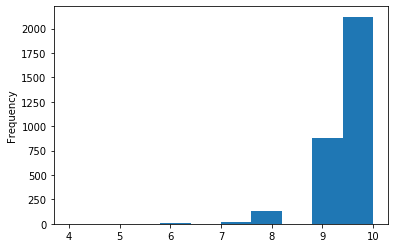

In [33]:
df_listings_clean['review_scores_location'].plot.hist()

I will impute the values with the mean, as the review data is pretty skewed and has some outliers. It's only a very small number, but I don't want to lose unnecessary price data.

In [34]:
fill_mean = lambda col: col.fillna(col.mean())

def impute_columns(df, column_list): 

    ''' 
    INPUT  
        df - the dataframe with columns having missing values to be imputed
        column_list - the columns of the given dataframe with missing values to be imputed    

    OUTPUT 
        df_imputed - a dataframe with specified columns imputed
    ''' 
    
    df_imputed = df.copy()

    for col in column_list:
        df_imputed[col] = fill_mean(df_imputed[col])
    
    return df_imputed 

In [35]:
review_cols = ['review_scores_rating', 'review_scores_checkin', 'review_scores_accuracy', 'review_scores_value',
               'review_scores_location', 'review_scores_cleanliness', 'review_scores_communication']

df_listings_clean = impute_columns(df_listings_clean, review_cols)

In [36]:
give_missing_values(df_listings_clean, visualize=True)

,column_name,percent_missing
bathrooms,bathrooms,0.38
bedrooms,bedrooms,0.19


In [37]:
df_listings_clean = impute_columns(df_listings_clean, ['bathrooms', 'bedrooms'])

### Sort Dataframe more intuitively

Currently, the Dataframe columns are all over the place. We want to sort them in a more logical structure.

In [38]:
df_listings_clean = df_listings_clean[['neighbourhood_group_cleansed', 
                                       'property_type', 'room_type', 'accommodates', 'beds', 'bedrooms', 'bathrooms',
                                       'bed_type', 'guests_included', 'extra_people', 'cancellation_policy', 'security_deposit_required',
                                       'minimum_nights', 'maximum_nights', 'availability_365', 'instant_bookable',
                                       'weekly_booking_available', 'monthly_booking_available',
                                       'number_of_reviews', 'review_scores_rating',
                                       'review_scores_accuracy', 'review_scores_communication', 
                                       'review_scores_location', 'review_scores_checkin', 'review_scores_value', 
                                       'host_about_available', 'host_thumbnail_available', 'host_since_in_days',
                                       'host_is_superhost', 'host_total_listings_count', 'host_identity_verified',
                                       'xl_picture_available',
                                       'notes_available', 'thumbnail_available',
                                       'require_guest_profile_picture', 'require_guest_phone_verification',
                                       'price']]

In [39]:
df_listings_clean.head(5)

,neighbourhood_group_cleansed,property_type,room_type,accommodates,beds,bedrooms,bathrooms,bed_type,guests_included,extra_people,...,host_since_in_days,host_is_superhost,host_total_listings_count,host_identity_verified,xl_picture_available,notes_available,thumbnail_available,require_guest_profile_picture,require_guest_phone_verification,price
0,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,2,5.0,...,1770.0,False,3.0,True,False,False,False,False,False,85.0
1,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,1,0.0,...,1210.0,True,6.0,True,True,True,True,True,True,150.0
2,Queen Anne,House,Entire home/apt,11,7.0,5.0,4.5,Real Bed,10,25.0,...,734.0,False,2.0,True,False,True,False,False,False,975.0
4,Queen Anne,House,Entire home/apt,6,3.0,3.0,2.0,Real Bed,6,15.0,...,1660.0,False,2.0,True,False,True,False,False,False,450.0
5,Queen Anne,House,Private room,2,1.0,1.0,1.0,Real Bed,1,30.0,...,1999.0,False,1.0,True,True,True,True,False,False,120.0


In [40]:
df_listings_clean.columns

Index(['neighbourhood_group_cleansed', 'property_type', 'room_type',
       'accommodates', 'beds', 'bedrooms', 'bathrooms', 'bed_type',
       'guests_included', 'extra_people', 'cancellation_policy',
       'security_deposit_required', 'minimum_nights', 'maximum_nights',
       'availability_365', 'instant_bookable', 'weekly_booking_available',
       'monthly_booking_available', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_location',
       'review_scores_checkin', 'review_scores_value', 'host_about_available',
       'host_thumbnail_available', 'host_since_in_days', 'host_is_superhost',
       'host_total_listings_count', 'host_identity_verified',
       'xl_picture_available', 'notes_available', 'thumbnail_available',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'price'],
      dtype='object')

In [41]:
df_listings_clean.shape

(3171, 37)

## 5 Data Modeling

### Linear Model

Build linear model to predict price.

#### Creating dummy columns

In [42]:
def create_dummy_df(df, cat_cols, dummy_na): 

    ''' 

    INPUT: 
        df - pandas dataframe with categorical variables you want to dummy 
        cat_cols - list of strings that are associated with names of the categorical columns 
        dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not 
    

    OUTPUT: 
        df - a new dataframe that has the following characteristics: 
                1. contains all columns that were not specified as categorical 
                2. removes all the original columns in cat_cols 
                3. dummy columns for each of the categorical columns in cat_cols 
                4. if dummy_na is True - it also contains dummy columns for the NaN values 
                5. Use a prefix of the column name with an underscore (_) for separating  
    ''' 

     

    for col in cat_cols: 
        try: 
            # for each cat add dummy var, drop original column 
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1) 
        except: 
            continue 

    return df 

In [43]:
cat_cols = ['neighbourhood_group_cleansed', 'room_type', 'property_type', 'bed_type', 'cancellation_policy']

In [44]:
df_listings_clean[cat_cols].head()

,neighbourhood_group_cleansed,room_type,property_type,bed_type,cancellation_policy
0,Queen Anne,Entire home/apt,Apartment,Real Bed,moderate
1,Queen Anne,Entire home/apt,Apartment,Real Bed,strict
2,Queen Anne,Entire home/apt,House,Real Bed,strict
4,Queen Anne,Entire home/apt,House,Real Bed,strict
5,Queen Anne,Private room,House,Real Bed,strict


In [45]:
df_listings_dummy = create_dummy_df(df_listings_clean, cat_cols, dummy_na=False)

In [46]:
df_listings_dummy.head()

,accommodates,beds,bedrooms,bathrooms,guests_included,extra_people,security_deposit_required,minimum_nights,maximum_nights,availability_365,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,4,1.0,1.0,1.0,2,5.0,False,1,365,346,...,0,0,0,0,0,0,0,1,1,0
1,4,1.0,1.0,1.0,1,0.0,True,2,90,291,...,0,0,0,0,0,0,0,1,0,1
2,11,7.0,5.0,4.5,10,25.0,True,4,30,220,...,0,0,0,0,0,0,0,1,0,1
4,6,3.0,3.0,2.0,6,15.0,True,1,1125,365,...,0,0,0,0,0,0,0,1,0,1
5,2,1.0,1.0,1.0,1,30.0,False,1,6,302,...,0,0,0,0,0,0,0,1,0,1


In [47]:
df_listings_dummy.columns

Index(['accommodates', 'beds', 'bedrooms', 'bathrooms', 'guests_included',
       'extra_people', 'security_deposit_required', 'minimum_nights',
       'maximum_nights', 'availability_365', 'instant_bookable',
       'weekly_booking_available', 'monthly_booking_available',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_location',
       'review_scores_checkin', 'review_scores_value', 'host_about_available',
       'host_thumbnail_available', 'host_since_in_days', 'host_is_superhost',
       'host_total_listings_count', 'host_identity_verified',
       'xl_picture_available', 'notes_available', 'thumbnail_available',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'price', 'neighbourhood_group_cleansed_Beacon Hill',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Cascade',
       'neighbourhood_group_cleansed_Central Area',
     

#### Creating the model

I had to drop 'thumbnail_available' and 'host_thumbnail_available' as they led to very strange results.

In [48]:
X= df_listings_dummy.drop(['price', 'thumbnail_available', 'host_thumbnail_available'], axis=1)
#X= df_listings_dummy.drop(['price'], axis=1)
y= df_listings_dummy['price']

**Test_size:** percentage of original datasat (rows) going to be used for the test <br>
**Random_state:** seed for the generated sample distribution

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42) 

**Normalilze:** safe thing and required for many ML and other models, very small downside:  can lead to reduction in interpretation of the feature 

In [50]:
lm_model = LinearRegression(normalize=True)

#### Fit

Fit model by using training data.

In [51]:
reg = lm_model.fit(X_train, y_train)

In [52]:
reg.score(X, y)

0.5507120699447746

#### Predict

Predict using both, test and training data sets to see if the model is overfitting.

In [53]:
y_test_preds = lm_model.predict(X_test)

In [54]:
y_train_preds = lm_model.predict(X_train)

In [55]:
y_train_preds

array([ 77.68474071,  75.8967814 ,  78.21464201, ..., 228.34274392,
       119.56770214, 172.03125918])

**Checking r_squared**

In [56]:
r2_test = r2_score(y_test, y_test_preds)

In [57]:
r2_test

0.47310908623772097

In [58]:
r2_train = r2_score(y_train, y_train_preds)

In [59]:
r2_train

0.5872947785883351

### Finding the best model

In [60]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .3, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)
    print(best_cutoff)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    print(num_feats)
    print(r2_scores_test)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

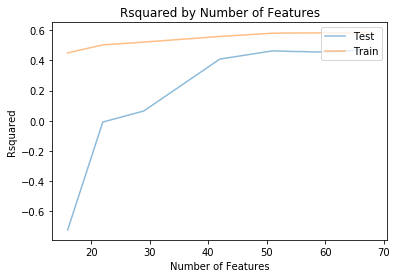

1
[16, 22, 29, 42, 51, 55, 56, 58, 62, 67, 68, 67]
[-0.7246835597825292, -0.008671260338529274, 0.06438080930996926, 0.4092427479007996, 0.4636035521134898, 0.4591468058312175, 0.4588993113477815, 0.45663899080964543, 0.4577960805109903, 0.473691431496047, 0.47310908623772097]


In [61]:
cutoffs = [5000, 2500, 1000, 100, 50, 30, 25, 10, 5, 1, 0]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [62]:
max(r2_scores_test)

0.473691431496047

The model is performing best with 67 features.

### Show coefficients

In [63]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
54,property_type_Dorm,-250.979528,250.979528
48,property_type_Boat,73.111074,73.111074
46,room_type_Shared room,-71.177915,71.177915
60,property_type_Treehouse,63.018812,63.018812
31,neighbourhood_group_cleansed_Cascade,45.441637,45.441637
34,neighbourhood_group_cleansed_Downtown,40.488611,40.488611
45,room_type_Private room,-36.368514,36.368514
40,neighbourhood_group_cleansed_Queen Anne,34.493469,34.493469
2,bedrooms,31.149006,31.149006
52,property_type_Chalet,29.831029,29.831029


## 6 Answering Business Questions

### Question 1 - Most expensive and lucrative areas

In [64]:
df_neighbourhood_price = df_listings_clean.groupby(['neighbourhood_group_cleansed']).agg(['mean', 'count'])[[('price',  'mean'), ('price',  'count')]].sort_values(by=[('price',  'mean')], ascending=False)
df_neighbourhood_price = round(df_neighbourhood_price,ndigits=2)
print(df_neighbourhood_price)

                               price      
                                mean count
neighbourhood_group_cleansed              
Magnolia                      185.83    47
Queen Anne                    161.40   246
Downtown                      154.28   456
Cascade                       145.34    65
Capitol Hill                  129.14   460
West Seattle                  128.99   162
Central Area                  126.12   319
Ballard                       123.65   193
Other neighborhoods           118.00   656
Seward Park                   108.10    39
University District            97.31    96
Lake City                      94.00    56
Rainier Valley                 90.36   134
Northgate                      90.15    65
Interbay                       89.67     9
Beacon Hill                    88.92   103
Delridge                       81.37    65


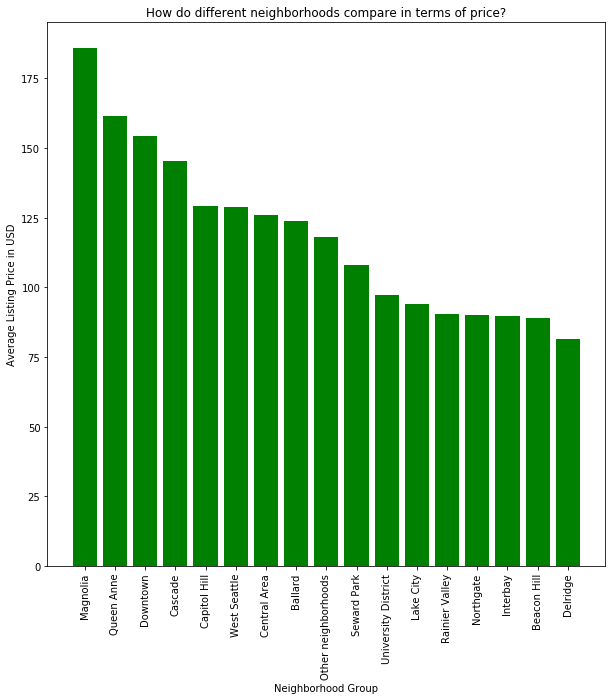

In [82]:
x = df_neighbourhood_price.index
y = df_neighbourhood_price[('price',  'mean')]

x_pos = [i for i, _ in enumerate(x)]


plt.figure(figsize=(10, 10))

plt.xticks(rotation='vertical')
plt.bar(x_pos, y, color='green')
plt.xlabel("Neighborhood Group")
plt.ylabel("Average Listing Price in USD")
plt.title("How do different neighborhoods compare in terms of price?")
plt.xticks(x_pos, x)

plt.show()

We can see that prices are highest in Magnolia, Queen Anne, Downtown and Cascade. While the bar chart only shows the average prices, it doesn't take into account other factors that might influence those prices. Therefore I will look at the coefficients of the linear model.

In [66]:
coef_df[coef_df['est_int'].str.contains("neighbourhood_group_cleansed")].sort_values(by=['coefs'],ascending=False)

,est_int,coefs,abs_coefs
31,neighbourhood_group_cleansed_Cascade,45.441637,45.441637
34,neighbourhood_group_cleansed_Downtown,40.488611,40.488611
40,neighbourhood_group_cleansed_Queen Anne,34.493469,34.493469
37,neighbourhood_group_cleansed_Magnolia,23.329941,23.329941
30,neighbourhood_group_cleansed_Capitol Hill,21.277759,21.277759
44,neighbourhood_group_cleansed_West Seattle,4.153797,4.153797
32,neighbourhood_group_cleansed_Central Area,1.550378,1.550378
39,neighbourhood_group_cleansed_Other neighborhoods,0.788138,0.788138
43,neighbourhood_group_cleansed_University District,-0.626807,0.626807
35,neighbourhood_group_cleansed_Interbay,-2.671745,2.671745


Looking at the top 4 coefficients, we can see that the same neighbourhoods that have the highest prices on average also have the highest positive impact on price. Interestingly, the order is different, though. It looks like there might be other factors than the location itself that drive prices up in Queen Anne and Magnlolia, which rank #1 and #2 on the average price but only #3 and #4 when it comes to the coefficients. 

### Question 2 - Which factors influence prices the most?

While answering question 1, we have seen that other factors apart from the neighborhood seem to influence prices. We can check our coefficient list to identify them.

#### Top 10 Factors having a positive impact on price

In [67]:
coef_df[coef_df['coefs'] > 0].sort_values(by=['coefs'],ascending=False).head(10)

,est_int,coefs,abs_coefs
48,property_type_Boat,73.111074,73.111074
60,property_type_Treehouse,63.018812,63.018812
31,neighbourhood_group_cleansed_Cascade,45.441637,45.441637
34,neighbourhood_group_cleansed_Downtown,40.488611,40.488611
40,neighbourhood_group_cleansed_Queen Anne,34.493469,34.493469
2,bedrooms,31.149006,31.149006
52,property_type_Chalet,29.831029,29.831029
61,bed_type_Couch,27.823918,27.823918
3,bathrooms,27.352084,27.352084
49,property_type_Bungalow,26.934722,26.934722


While 3 of 4 neighbourhoods we identified as most expensive are in the list of top 10 factors positively influencing price, we can clearly see that other factors play a role as well.

The property type appears 4 times in the top 10 list. Exclusive and fancy property types like boats, treehouses or chalets have a very strong impact on prices. Boats and treehouses raise the price by 60-75 dollars. This makes sense as I could imagine that people who love to travel want to have a unique experience and are therefore willing to pay more for such unusual housing types.

The number of bedrooms and bathrooms also have a strong positive correlation with price. This makes sense as an increasing number of bedrooms and bathrooms mean that the property can accomodate more people. As you don't pay per person but usually rent the whole place the price can be shared amongs more people. We would probabaly see a similar correlation when it comes to the size of the apartment, but unfortunately those values were not available for most listings. Therefore I had to drop the square feet column.

#### Top 10 Factors having a negative impact on price

In [68]:
coef_df[coef_df['coefs'] < 0].sort_values(by=['coefs'], ascending=True).head(10)

,est_int,coefs,abs_coefs
54,property_type_Dorm,-250.979528,250.979528
46,room_type_Shared room,-71.177915,71.177915
45,room_type_Private room,-36.368514,36.368514
33,neighbourhood_group_cleansed_Delridge,-20.507491,20.507491
41,neighbourhood_group_cleansed_Rainier Valley,-15.922961,15.922961
29,neighbourhood_group_cleansed_Beacon Hill,-14.974473,14.974473
38,neighbourhood_group_cleansed_Northgate,-13.335791,13.335791
25,xl_picture_available,-11.416893,11.416893
10,instant_bookable,-9.482289,9.482289
19,review_scores_value,-9.118026,9.118026


Now looking at the most negative influencing factors, we see neighborhoods are again present here. Delridge, Rainer Valley, Beacon Hill and Northgate are also among the lowest 5 when it comes to average prices.

If your propoerty type is a dorm, prices will be around 251 dollars lower, according to the model. This aligns with the second strongest negative influence: whether the room is shared or not. 

The same trend can be seen when looking at number three in terms of negative influence. A private room also seems to lower the price a potential landlord could ask for. While private room sounds like the opposite of a shared room, it actually still means you could share other rooms and amenities with other people. This is the definition of a private room, according to Airbnb:

_"Private rooms are great when you prefer a little privacy, yet still value a local connection. When you book a private room, you'll have your own private room for sleeping and may share some spaces with others. You might need to walk through indoor spaces that another host or guest may occupy to get to your room."_

All the other coefficients only have a small negative impact on the room price. 

In [69]:
print("Coefficients having a positive impact:")
print(coef_df[coef_df['coefs'] > 0].count()[0])
print("Coefficients having a negative impact:")
print(coef_df[coef_df['coefs'] < 0].count()[0])

Coefficients having a positive impact:
38
Coefficients having a negative impact:
29


### Question 3 - Should our friend invest in his apartment?

In the following analysis I will look at two options:
- Rent room as a loft for one person
- Split rooms and rent two private rooms that share bathroom and kitchen. Since my friend currently only has one bed, one room is only equipped with a couch.

In [70]:
cols = pd.DataFrame(X_test.columns)

In [71]:
cols.to_csv(r'C:\Users\carst\OneDrive\04 Coding\Udacity-Data-Science\Project 1\Data\cols.csv', index = True)

In [72]:
samples_filled = pd.read_csv('./Data/samples_filled.csv', delimiter=';')
samples_filled = samples_filled.drop(labels='ColNumber',axis=1)

In [73]:
samples_filled.head(10)

,ColName,Loft,Shared_1,Shared_2
0,accommodates,1.0,1.0,1.0
1,beds,1.0,1.0,1.0
2,bedrooms,1.0,1.0,1.0
3,bathrooms,1.0,1.0,1.0
4,guests_included,2.0,2.0,2.0
5,extra_people,3.0,3.0,3.0
6,security_deposit_required,1.0,1.0,1.0
7,minimum_nights,1.0,1.0,1.0
8,maximum_nights,30.0,30.0,30.0
9,availability_365,365.0,365.0,365.0


In [74]:
samples_filled[samples_filled['Loft'].isna()]

,ColName,Loft,Shared_1,Shared_2
14,review_scores_rating,NaN,NaN,NaN
15,review_scores_accuracy,NaN,NaN,NaN
16,review_scores_communication,NaN,NaN,NaN
17,review_scores_location,NaN,NaN,NaN
18,review_scores_checkin,NaN,NaN,NaN
19,review_scores_value,NaN,NaN,NaN


In [75]:
null_feature_cols = samples_filled[samples_filled['Loft'].isna()]['ColName']
print(null_feature_cols)

14           review_scores_rating
15         review_scores_accuracy
16    review_scores_communication
17         review_scores_location
18          review_scores_checkin
19            review_scores_value
Name: ColName, dtype: object


Since the listing is not online yet, there are no ratings. I can't feed the model with NaN values, therefore I will use the mean of our dataset.

In [76]:
review_means = df_listings_clean[null_feature_cols].mean()
review_means

review_scores_rating           94.539262
review_scores_accuracy          9.636392
review_scores_communication     9.809599
review_scores_location          9.608916
review_scores_checkin           9.786709
review_scores_value             9.452245
dtype: float64

In [77]:
for index in null_feature_cols.index:
    samples_filled.iloc[index,:] = samples_filled.iloc[index,:].fillna(review_means[index-14])

Let's check where our samples are different.

In [78]:
samples_filled[samples_filled['Loft'] != samples_filled['Shared_2']]

,ColName,Loft,Shared_1,Shared_2
45,room_type_Private room,0.0,1.0,1.0
56,property_type_Loft,1.0,0.0,0.0
63,bed_type_Pull-out Sofa,0.0,0.0,1.0
64,bed_type_Real Bed,1.0,1.0,0.0


Predict prices using our linear model.

In [85]:
samples_filled_model = samples_filled.set_index('ColName').transpose()
samples_pred = lm_model.predict(samples_filled_model)
samples_pred = round(pd.DataFrame(samples_pred), 2)

In [86]:
samples_pred

,0
0,158.05
1,102.14
2,93.31


In [83]:
print("Option 1: " + str(samples_pred[0][0]) + " dollars per night.")
print("Option 2: " + str(samples_pred[0][1] + samples_pred[0][2]) + " dollars per night if both are rented.")

Option 1: 158.05 dollars per night.
Option 2: 195.45 dollars per night if both are rented.
